In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/'My Drive'

Mounted at /content/drive
/content/drive/My Drive


In [ ]:
!pip install -U fastai
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from fastai.tabular.core import add_datepart
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn import neighbors
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

     |████████████████████████████████| 189 kB 4.3 MB/s 
     |████████████████████████████████| 56 kB 3.9 MB/s 
  Attempting uninstall: fastai
    Found existing installation: fastai 1.0.61
    Uninstalling fastai-1.0.61:
      Successfully uninstalled fastai-1.0.61


**Data Loading**

In [ ]:
df = pd.read_csv('BSE-TATAMOTORS.csv')
X_future = pd.read_csv('BSE-TATAMOTORS-Future.csv')

In [ ]:
df.shape

(7486, 13)

In [ ]:
# Output variable: Close(Datatype: float64)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7486 entries, 0 to 7485
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Date                       7486 non-null   object 
 1   Open                       7486 non-null   float64
 2   High                       7486 non-null   float64
 3   Low                        7486 non-null   float64
 4   Close                      7486 non-null   float64
 5   WAP                        7486 non-null   float64
 6   No. of Shares              7486 non-null   int64  
 7   No. of Trades              7486 non-null   int64  
 8   Total Turnover             7486 non-null   int64  
 9   Deliverable Quantity       4908 non-null   float64
 10  % Deli. Qty to Traded Qty  4908 non-null   float64
 11  Spread H-L                 7486 non-null   float64
 12  Spread C-O                 7486 non-null   float64
dtypes: float64(9), int64(3), object(1)
memory usage:

In [ ]:
df.head()

,Date,Open,High,Low,Close,WAP,No. of Shares,No. of Trades,Total Turnover,Deliverable Quantity,% Deli. Qty to Traded Qty,Spread H-L,Spread C-O
0,11/30/2021,465.55,478.00,455.80,458.80,469.13,1287893,21020,604183376,261403.0,20.30,22.20,-6.75
1,11/29/2021,454.20,470.35,442.90,461.25,459.24,4104330,84997,1884875335,1802416.0,43.91,27.45,7.05
2,11/26/2021,485.05,486.95,458.00,460.25,468.92,4111286,134332,1927856443,1714988.0,41.71,28.95,-24.80
3,11/25/2021,491.10,495.00,486.35,492.75,490.46,1112012,27386,545399517,352486.0,31.70,8.65,1.65
4,11/24/2021,499.65,502.00,485.80,488.70,496.03,847176,15664,420227593,215154.0,25.40,16.20,-10.95


In [ ]:
df.describe()

,Open,High,Low,Close,WAP,No. of Shares,No. of Trades,Total Turnover,Deliverable Quantity,% Deli. Qty to Traded Qty,Spread H-L,Spread C-O
count,7486.000000,7486.000000,7486.000000,7486.000000,7486.000000,7.486000e+03,7486.000000,7.486000e+03,4.908000e+03,4908.000000,7486.000000,7486.000000
mean,390.131385,396.519496,383.066103,389.522642,344.015673,1.040460e+06,8713.300027,3.256714e+08,3.283339e+05,26.729839,13.453393,-0.608743
std,241.746994,245.062595,237.696945,241.279300,270.849651,1.918767e+06,10806.778502,7.634748e+08,1.530256e+06,14.736759,11.551577,10.530853
min,59.000000,60.500000,58.000000,58.850000,0.000000,0.000000e+00,0.000000,0.000000e+00,3.133000e+03,2.890000,0.000000,-97.800000
25%,194.050000,198.812500,190.000000,194.100000,140.228639,2.345345e+05,2202.250000,7.095126e+07,9.547250e+04,16.270000,6.300000,-4.900000
50%,350.900000,357.500000,344.225000,350.875000,306.674234,5.953100e+05,6115.000000,2.086265e+08,1.779690e+05,24.230000,10.000000,-0.450000
75%,495.000000,502.500000,487.112500,494.900000,472.796175,1.261632e+06,11665.500000,4.023775e+08,3.337952e+05,34.187500,16.500000,3.800000
max,1365.450000,1381.400000,1346.800000,1365.600000,1363.673006,8.410000e+07,164374.000000,3.807770e+10,8.376508e+07,304.280000,229.900000,78.200000


**Process Data**

In [ ]:
# Check for Missing values in data
df[(df.isna().any(axis=1))]

,Date,Open,High,Low,Close,WAP,No. of Shares,No. of Trades,Total Turnover,Deliverable Quantity,% Deli. Qty to Traded Qty,Spread H-L,Spread C-O
1478,12/9/2015,402.4,404.85,392.85,393.95,397.930000,470588,7449,187260567,NaN,NaN,12.00,-8.45
3268,9/15/2008,400.0,405.00,383.25,390.60,390.409112,260061,4775,101530184,NaN,NaN,21.75,-9.40
3269,9/12/2008,430.0,430.00,403.00,411.85,422.696295,273894,3866,115773979,NaN,NaN,27.00,-18.15
3270,9/11/2008,430.0,437.00,413.05,424.15,422.052693,199058,3310,84012965,NaN,NaN,23.95,-5.85
3271,9/10/2008,416.5,421.45,416.05,418.55,418.040204,113595,2786,47487277,NaN,NaN,5.40,2.05
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7481,1/11/1991,170.0,175.00,167.50,175.00,0.000000,0,0,0,NaN,NaN,7.50,5.00
7482,1/9/1991,177.5,177.50,167.50,171.25,0.000000,0,0,0,NaN,NaN,10.00,-6.25
7483,1/7/1991,170.0,177.50,167.50,176.25,0.000000,0,0,0,NaN,NaN,10.00,6.25
7484,1/3/1991,175.0,182.50,175.00,182.50,0.000000,0,0,0,NaN,NaN,7.50,7.50


In [ ]:
df = df.dropna()

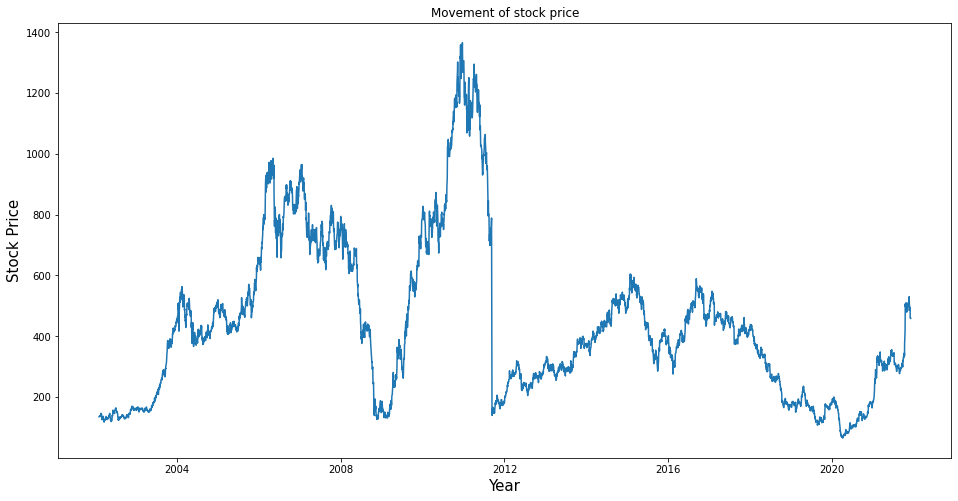

In [ ]:
# setting index as date
df.index = pd.to_datetime(df.Date,format='%m/%d/%Y')

plt.figure(figsize=(16,8))
plt.plot(df['Close'], label='Close Price history')
plt.xlabel('Year', fontsize=15)
plt.ylabel('Stock Price', fontsize=15)
plt.title('Movement of stock price')
plt.show()

In [ ]:
sorted_df = df.sort_index(ascending=True, axis=0)
sorted_df.head()

,Date,Open,High,Low,Close,WAP,No. of Shares,No. of Trades,Total Turnover,Deliverable Quantity,% Deli. Qty to Traded Qty,Spread H-L,Spread C-O
Date,,,,,,,,,,,,,
2002-02-08,2/8/2002,138.00,140.5,134.00,135.10,137.573524,550807,4728,75776460,80314.0,14.58,6.50,-2.9
2002-02-15,2/15/2002,142.75,144.5,138.25,138.95,140.700632,1304457,7242,183537925,367425.0,28.17,6.25,-3.8
2002-02-18,2/18/2002,140.00,141.5,136.25,137.90,138.244920,313058,2174,43278678,111392.0,35.58,5.25,-2.1
2002-02-19,2/19/2002,137.50,142.0,136.20,136.80,139.466944,736870,4155,102769007,195980.0,26.60,5.80,-0.7
2002-02-20,2/20/2002,137.00,138.9,135.00,136.90,137.311892,363260,2654,49879918,70573.0,19.43,3.90,-0.1


**Feature Selection**

In [ ]:
data = pd.DataFrame(columns=['Date', 'Close'])

data['Date'] = sorted_df['Date'].values
data['Close'] = sorted_df['Close'].values

data.head()

,Date,Close
0,2/8/2002,135.10
1,2/15/2002,138.95
2,2/18/2002,137.90
3,2/19/2002,136.80
4,2/20/2002,136.90


In [ ]:
# Adding new features

add_datepart(data, 'Date')
data.index = sorted_df.index
data.drop('Elapsed', axis=1, inplace=True)
data.head()

,Close,Year,Month,Week,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start
Date,,,,,,,,,,,,,
2002-02-08,135.10,2002,2,6,8,4,39,False,False,False,False,False,False
2002-02-15,138.95,2002,2,7,15,4,46,False,False,False,False,False,False
2002-02-18,137.90,2002,2,8,18,0,49,False,False,False,False,False,False
2002-02-19,136.80,2002,2,8,19,1,50,False,False,False,False,False,False
2002-02-20,136.90,2002,2,8,20,2,51,False,False,False,False,False,False


**Split Data into Training and Testing datasets**

In [ ]:
ratio = 0.2
label = data['Close']
features = data.drop('Close', axis=1)
X_train, X_test, y_train, y_test = train_test_split(features, label, test_size=ratio, shuffle=False)
X_train.head()

,Year,Month,Week,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start
Date,,,,,,,,,,,,
2002-02-08,2002,2,6,8,4,39,False,False,False,False,False,False
2002-02-15,2002,2,7,15,4,46,False,False,False,False,False,False
2002-02-18,2002,2,8,18,0,49,False,False,False,False,False,False
2002-02-19,2002,2,8,19,1,50,False,False,False,False,False,False
2002-02-20,2002,2,8,20,2,51,False,False,False,False,False,False


In [ ]:
X_future_common = X_future.copy(deep=True)
X_future_common.head()

,Date
0,12/1/2021
1,12/2/2021
2,12/3/2021
3,12/6/2021
4,12/7/2021


In [ ]:
index = pd.to_datetime(X_future_common['Date'],format='%m/%d/%Y')
add_datepart(X_future_common, 'Date')
X_future_common.index = index
X_future_common.drop('Elapsed', axis=1, inplace=True)  #elapsed will be the time stamp
X_future_common.head()

,Year,Month,Week,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start
Date,,,,,,,,,,,,
2021-12-01,2021,12,48,1,2,335,False,True,False,False,False,False
2021-12-02,2021,12,48,2,3,336,False,False,False,False,False,False
2021-12-03,2021,12,48,3,4,337,False,False,False,False,False,False
2021-12-06,2021,12,49,6,0,340,False,False,False,False,False,False
2021-12-07,2021,12,49,7,1,341,False,False,False,False,False,False


##Linear Regression

In [ ]:
#implement linear regression
model = LinearRegression()
model.fit(X_train,y_train)

LinearRegression()

In [ ]:
# make predictions
preds_train = model.predict(X_train)
preds = model.predict(X_test)

# R-square
r2_linear_test = r2_score(y_test, preds)
print('R-Square on test set: ', r2_linear_test)

r2_linear_train = r2_score(y_train, preds_train)
print('R-Square on train set: ', r2_linear_train)

# MAE
mae_linear_test = mean_absolute_error(y_test, preds)
print('MAE on test set: ', mae_linear_test)

mae_linear_train = mean_absolute_error(y_train, preds_train)
print('MAE on train set: ', mae_linear_train)

# RMSE
rms_linear_test = mean_squared_error(y_test, preds, squared=False)
print('RMSE on test set: ', rms_linear_test)

rms_linear_train = mean_squared_error(y_train, preds_train, squared=False)
print('RMSE on train set: ', rms_linear_train)

R-Square on test set:  -8.055749784008615
R-Square on train set:  0.011878675948811757
MAE on test set:  294.0406227484368
MAE on train set:  206.25079339225843
RMSE on test set:  310.70033944685406
RMSE on train set:  262.0718796074832


In [ ]:
y_train_pred_lr = pd.DataFrame(columns=['Predictions'])
y_train_pred_lr['Predictions'] = preds_train
y_train_pred_lr.index = y_train.index

y_test_pred_lr = pd.DataFrame(columns=['Predictions'])
y_test_pred_lr['Predictions'] = preds
y_test_pred_lr.index = y_test.index

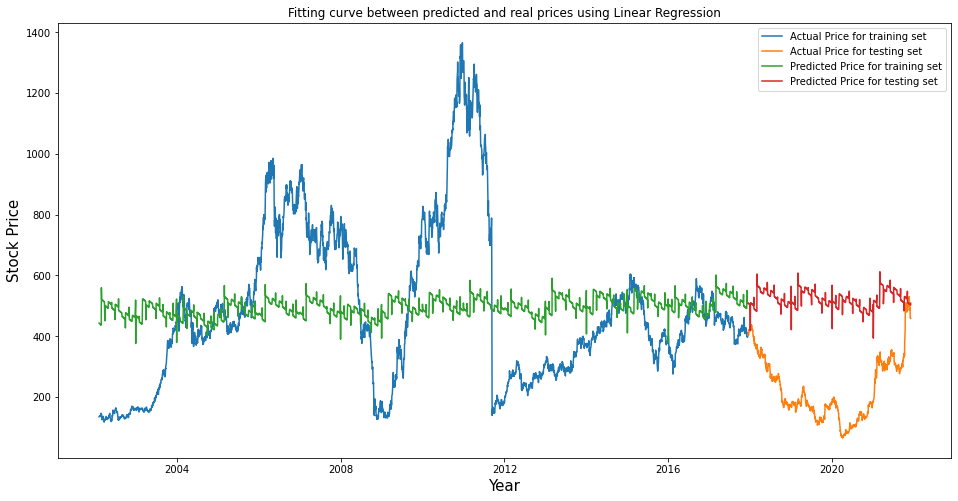

In [ ]:
plt.figure(figsize=(16,8))
plt.plot(y_train, label='Actual Price for training set')
plt.plot(y_test, label='Actual Price for testing set')
plt.plot(y_train_pred_lr, label='Predicted Price for training set')
plt.plot(y_test_pred_lr, label='Predicted Price for testing set')
plt.xlabel('Year', fontsize=15)
plt.ylabel('Stock Price', fontsize=15)
plt.title('Fitting curve between predicted and real prices using Linear Regression')
plt.legend()

plt.show()

In [ ]:
future_preds_lr = model.predict(X_future_common)
future_preds_lr

array([561.26512622, 524.28873126, 524.48415932, 521.53587771,
       521.73130578, 521.92673384, 522.12216191, 522.31758998,
       519.36930836, 519.56473643])

##k-Nearest Neighbors

In [ ]:
# scaling data
scaler = MinMaxScaler(feature_range=(0, 1))
X_train_scaled = scaler.fit_transform(X_train)
X_train = pd.DataFrame(X_train_scaled)
X_test_scaled = scaler.fit_transform(X_test)
X_test = pd.DataFrame(X_test_scaled)
X_future_common_scaled = scaler.fit_transform(X_future_common)
X_future_common = pd.DataFrame(X_future_common_scaled)

In [ ]:
# using gridsearch to find the best parameter
params = {'n_neighbors':[2,3,4,5,6,7,8,9]}
knn = neighbors.KNeighborsRegressor()
clf = GridSearchCV(knn, params, cv=5)

# fit the model and make predictions
search = clf.fit(X_train,y_train)

model = search.best_estimator_ 
print(model)

KNeighborsRegressor(n_neighbors=9)


In [ ]:
preds = model.predict(X_test)
preds_train = model.predict(X_train)

# R-square
r2_knn_test = r2_score(y_test, preds)
print('R-Square on test set: ', r2_knn_test)

r2_knn_train = r2_score(y_train, preds_train)
print('R-Square on train set: ', r2_knn_train)

# MAE
mae_knn_test = mean_absolute_error(y_test, preds)
print('MAE on test set: ', mae_knn_test)

mae_knn_train = mean_absolute_error(y_train, preds_train)
print('MAE on train set: ', mae_knn_train)

# RMSE
rms_knn_test = mean_squared_error(y_test, preds, squared=False)
print('RMSE on test set: ', rms_knn_test)

rms_knn_train = mean_squared_error(y_train, preds_train, squared=False)
print('RMSE on train set: ', rms_knn_train)

R-Square on test set:  -10.41213358976908
R-Square on train set:  0.5064728015274529
MAE on test set:  310.2338877574112
MAE on train set:  133.13166921378843
RMSE on test set:  348.7891318949178
RMSE on train set:  185.21273016697342


In [ ]:
y_test_pred_knn = pd.DataFrame(columns=['Predictions'])
y_test_pred_knn['Predictions'] = preds
y_test_pred_knn.index = y_test.index

y_train_pred_knn = pd.DataFrame(columns=['Predictions'])
y_train_pred_knn['Predictions'] = preds_train
y_train_pred_knn.index = y_train.index

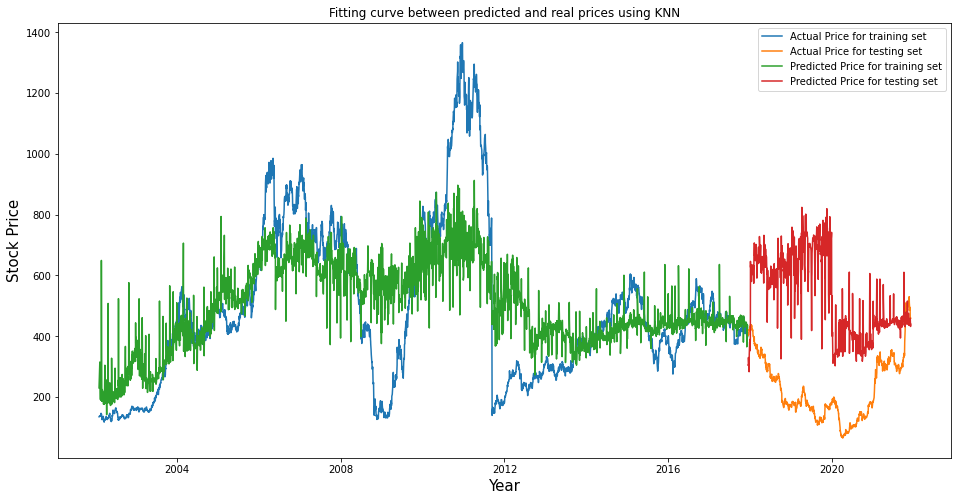

In [ ]:
plt.figure(figsize=(16,8))
plt.plot(y_train, label='Actual Price for training set')
plt.plot(y_test, label='Actual Price for testing set')
plt.plot(y_train_pred_knn, label='Predicted Price for training set')
plt.plot(y_test_pred_knn, label='Predicted Price for testing set')
plt.xlabel('Year', fontsize=15)
plt.ylabel('Stock Price', fontsize=15)
plt.title('Fitting curve between predicted and real prices using KNN')
plt.legend()

plt.show()

In [ ]:
future_preds_knn = model.predict(X_future_common)
future_preds_knn

array([625.35      , 340.29444444, 340.29444444, 218.62222222,
       187.02222222, 215.38888889, 222.68333333, 295.38333333,
       236.21111111, 251.66666667])

##SVM

In [ ]:
params = {'C': [0.001, 0.01, 0.1], 'kernel': ['linear', 'rbf'], 'gamma': [0.001, 0.01, 0.1]}
svm = SVR()
clf = GridSearchCV(svm, params, cv=5)
search = clf.fit(X_train, y_train)
model = search.best_estimator_
print(model)

SVR(C=0.001, gamma=0.001)


In [ ]:
preds = model.predict(X_test)
preds_train = model.predict(X_train)

# R-square
r2_svm_test = r2_score(y_test, preds)
print('R-Square on test set: ', r2_svm_test)

r2_svm_train = r2_score(y_train, preds_train)
print('R-Square on train set: ', r2_svm_train)

# MAE
mae_svm_test = mean_absolute_error(y_test, preds)
print('MAE on test set: ', mae_svm_test)

mae_svm_train = mean_absolute_error(y_train, preds_train)
print('MAE on train set: ', mae_svm_train)

# RMSE
rms_svm_test = mean_squared_error(y_test, preds, squared=False)
print('RMSE on test set: ', rms_svm_test)

rms_svm_train = mean_squared_error(y_train, preds_train, squared=False)
print('RMSE on train set: ', rms_svm_train)

R-Square on test set:  -4.21115322146435
R-Square on train set:  -0.04282680959895835
MAE on test set:  215.42679785102882
MAE on train set:  198.68171719279349
RMSE on test set:  235.69286849743978
RMSE on train set:  269.2287169827309


In [ ]:
y_test_pred_svm = pd.DataFrame(columns=['Predictions'])
y_test_pred_svm['Predictions'] = preds
y_test_pred_svm.index = y_test.index

y_train_pred_svm = pd.DataFrame(columns=['Predictions'])
y_train_pred_svm['Predictions'] = preds_train
y_train_pred_svm.index = y_train.index

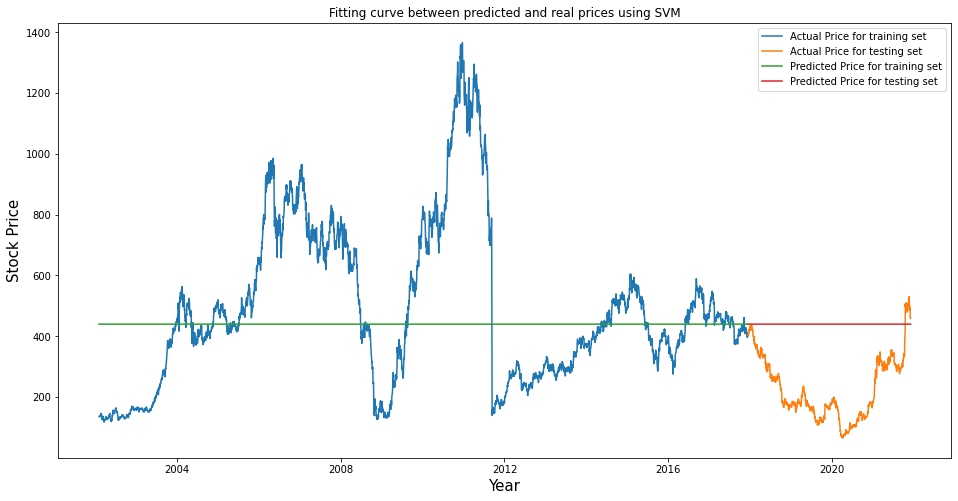

In [ ]:
plt.figure(figsize=(16,8))
plt.plot(y_train, label='Actual Price for training set')
plt.plot(y_test, label='Actual Price for testing set')
plt.plot(y_train_pred_svm, label='Predicted Price for training set')
plt.plot(y_test_pred_svm, label='Predicted Price for testing set')
plt.xlabel('Year', fontsize=15)
plt.ylabel('Stock Price', fontsize=15)
plt.title('Fitting curve between predicted and real prices using SVM')
plt.legend()

plt.show()

In [ ]:
future_preds_svm = model.predict(X_future_common)
future_preds_svm

array([439.90021393, 439.90020004, 439.90018997, 439.90009993,
       439.90008989, 439.90007984, 439.90006978, 439.90005973,
       439.89996966, 439.89995963])

##Random forest

In [ ]:
params = {'n_estimators': [100, 200, 300], 'max_features': ['auto', 'sqrt']}
random_forest = RandomForestRegressor(random_state=42)
clf = GridSearchCV(random_forest, params, n_jobs=5, cv=5)
search = clf.fit(X_train, y_train)
model = search.best_estimator_
print(model)

RandomForestRegressor(max_features='sqrt', n_estimators=300, random_state=42)


In [ ]:
preds = model.predict(X_test)
preds_train = model.predict(X_train)

# R-square
r2_rf_test = r2_score(y_test, preds)
print('R-Square on test set: ', r2_rf_test)

r2_rf_train = r2_score(y_train, preds_train)
print('R-Square on train set: ', r2_rf_train)

# MAE
mae_rf_test = mean_absolute_error(y_test, preds)
print('MAE on test set: ', mae_rf_test)

mae_rf_train = mean_absolute_error(y_train, preds_train)
print('MAE on train set: ', mae_rf_train)

# RMSE
rms_rf_test = mean_squared_error(y_test, preds, squared=False)
print('RMSE on test set: ', rms_rf_test)

rms_rf_train = mean_squared_error(y_train, preds_train, squared=False)
print('RMSE on train set: ', rms_rf_train)

R-Square on test set:  -8.36998281345737
R-Square on train set:  0.9764162028637674
MAE on test set:  282.3491681941616
MAE on train set:  28.885449269825116
RMSE on test set:  316.04499551803787
RMSE on train set:  40.48761111711376


In [ ]:
y_test_pred_rf = pd.DataFrame(columns=['Predictions'])
y_test_pred_rf['Predictions'] = preds
y_test_pred_rf.index = y_test.index

y_train_pred_rf = pd.DataFrame(columns=['Predictions'])
y_train_pred_rf['Predictions'] = preds_train
y_train_pred_rf.index = y_train.index

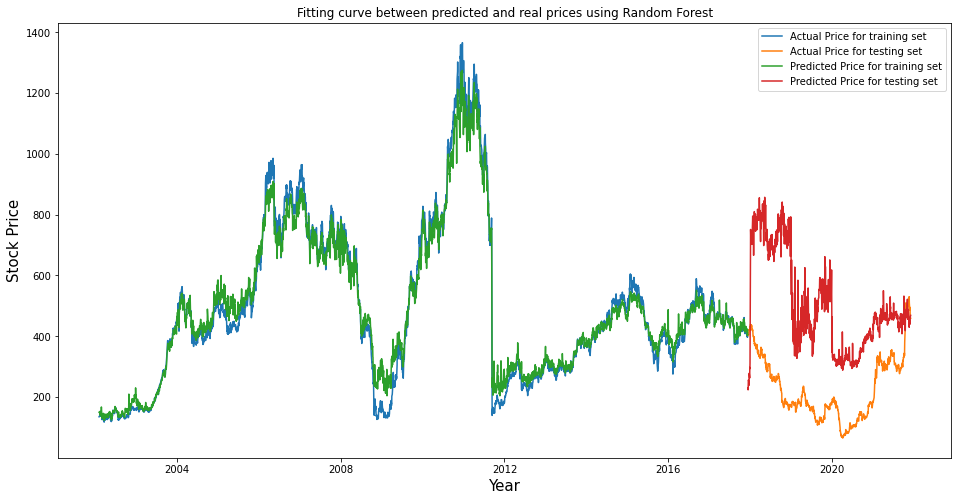

In [ ]:
plt.figure(figsize=(16,8))
plt.plot(y_train, label='Actual Price for training set')
plt.plot(y_test, label='Actual Price for testing set')
plt.plot(y_train_pred_rf, label='Predicted Price for training set')
plt.plot(y_test_pred_rf, label='Predicted Price for testing set')
plt.xlabel('Year', fontsize=15)
plt.ylabel('Stock Price', fontsize=15)
plt.title('Fitting curve between predicted and real prices using Random Forest')
plt.legend()

plt.show()

In [ ]:
future_preds_rf = model.predict(X_future_common)
future_preds_rf

array([233.35516667, 230.261     , 233.20933333, 165.14316667,
       161.19266667, 167.32866667, 166.2695    , 197.97183333,
       214.25366667, 247.60566667])

##LSTM

In [ ]:
data = pd.DataFrame(columns=['Date', 'Close'])

data['Date'] = sorted_df['Date'].values
data['Close'] = sorted_df['Close'].values
data.index = pd.to_datetime(data['Date'],format='%m/%d/%Y')
data.drop('Date', axis=1, inplace=True)

data.tail()

,Close
Date,
2021-11-24,488.70
2021-11-25,492.75
2021-11-26,460.25
2021-11-29,461.25
2021-11-30,458.80


In [ ]:
dataset = data.values
dataset

array([[135.1 ],
       [138.95],
       [137.9 ],
       ...,
       [460.25],
       [461.25],
       [458.8 ]])

In [ ]:
train_df, test_df = train_test_split(data, test_size=ratio, shuffle=False)
train_size = train_df.shape[0]

In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)
scaled_data

array([[0.05367992],
       [0.05664078],
       [0.05583327],
       ...,
       [0.3037376 ],
       [0.30450665],
       [0.30262247]])

In [ ]:
# converting dataset into X_train and y_train
X_train, y_train = [], []
sequence_len = 60
for i in range(sequence_len, train_size):
    X_train.append(scaled_data[i-sequence_len:i, 0])
    y_train.append(scaled_data[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train.shape

(3866, 60, 1)

In [ ]:
# create and fit the LSTM network
#neurons = [10, 20, 50, 100]
neurons = [50]
minimum = 100000
preds = []
best_model = Sequential()
for i, n in enumerate(neurons):
  model = Sequential()
  model.add(LSTM(units=n, return_sequences=True, input_shape=(X_train.shape[1],1)))
  model.add(LSTM(units=n))
  model.add(Dense(1))

  model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
  model.fit(X_train, y_train, epochs=1, batch_size=1, validation_split=0.1)

  inputs = data[len(data) - len(test_df) - sequence_len:].values
  inputs = inputs.reshape(-1,1)
  inputs  = scaler.transform(inputs)

  # predicting closing price for test set, using past 60 values from the train data
  X_test_i = []
  for i in range(len(test_df)):
      X_test_i.append(inputs[i:i+sequence_len, 0])
  X_test_i = np.array(X_test_i)
  X_test_i = np.reshape(X_test_i, (X_test_i.shape[0], X_test_i.shape[1], 1))

  preds = model.predict(X_test_i)
  preds = scaler.inverse_transform(preds)

  rms = rms = mean_squared_error(test_df.values, preds, squared=False)
  if rms < minimum:
    minimum = rms
    best_preds = preds 
    best_model = model

rms_lstm_test = minimum
preds = best_preds
model = best_model

3479/3479 [==============================] - 78s 21ms/step - loss: 0.0015 - accuracy: 2.8744e-04 - val_loss: 4.7144e-04 - val_accuracy: 0.0000e+00


In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 60, 50)            10400     
                                                                 
 lstm_3 (LSTM)               (None, 50)                20200     
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 30,651
Trainable params: 30,651
Non-trainable params: 0
_________________________________________________________________


In [ ]:
inputs_t = data.values
inputs_t = inputs_t.reshape(-1,1)
inputs_t  = scaler.transform(inputs_t)

# predicting closing price for train set
Xt = []
for i in range(len(train_df)-sequence_len):
    Xt.append(inputs_t[i:i+sequence_len, 0])
Xt = np.array(Xt)
Xt = np.reshape(Xt, (Xt.shape[0], Xt.shape[1], 1))

preds_train = model.predict(Xt)
preds_train = scaler.inverse_transform(preds_train)

rms_lstm_train = np.sqrt(np.mean(np.power((train_df.values[sequence_len:] - preds_train),2)))
print('RMSE on train set: ', rms_lstm_train)

RMSE on train set:  39.59679346954152


In [ ]:
# R-square
r2_lstm_test = r2_score(test_df.values, preds)
print('R-Square on test set: ', r2_lstm_test)

r2_lstm_train = r2_score(train_df.values[sequence_len:], preds_train)
print('R-Square on train set: ', r2_lstm_train)

# MAE
mae_lstm_test = mean_absolute_error(test_df.values, preds)
print('MAE on test set: ', mae_lstm_test)

mae_lstm_train = mean_absolute_error(train_df.values[sequence_len:], preds_train)
print('MAE on train set: ', mae_lstm_train)

# RMSE
rms_lstm_test = mean_squared_error(test_df.values, preds, squared=False)
print('RMSE on test set: ', rms_lstm_test)

rms_lstm_train = mean_squared_error(train_df.values[sequence_len:], preds_train, squared=False)
print('RMSE on train set: ', rms_lstm_train)

R-Square on test set:  0.9718432050387515
R-Square on train set:  0.9771184460986018
MAE on test set:  14.542314845627047
MAE on train set:  29.158167474058953
RMSE on test set:  17.32491568811755
RMSE on train set:  39.59679346954152


In [ ]:
for i in range(sequence_len):
  preds_train = np.concatenate([[dataset[i]], preds_train])

In [ ]:
# Predict price for n next days

n = 10
X_future_test = []
for i in range(0, n):
  X_future_test.append(inputs[-sequence_len:, 0])
  X_future_test_arr = np.array(X_future_test)
  X_future_test_arr = np.reshape(X_future_test_arr, (X_future_test_arr.shape[0], X_future_test_arr.shape[1], 1))
  
  nextday_closing_price = model.predict(X_future_test_arr)
  inputs = np.append(inputs, nextday_closing_price, 0)

# X_future_test.append(inputs[len(inputs) - sequence_len:, 0])
# X_future_test_arr = np.array(X_future_test)
# nextday_closing_price = model.predict(X_future_test_arr)

nextday_closing_price = scaler.inverse_transform(nextday_closing_price)

In [ ]:
nextday_closing_price

array([[491.73636],
       [496.68866],
       [513.34766],
       [527.9916 ],
       [537.55475],
       [548.88055],
       [561.06805],
       [573.8131 ],
       [587.3542 ],
       [601.61237]], dtype=float32)

In [ ]:
future_df = X_future.copy(deep=True)
index = pd.to_datetime(future_df['Date'],format='%m/%d/%Y')
future_df.index = index
future_df.drop('Date', axis=1, inplace=True)

In [ ]:
test_df['Predictions'] = preds
train_df['Predictions'] = preds_train
#future_df['Predictions'] = nextday_closing_price

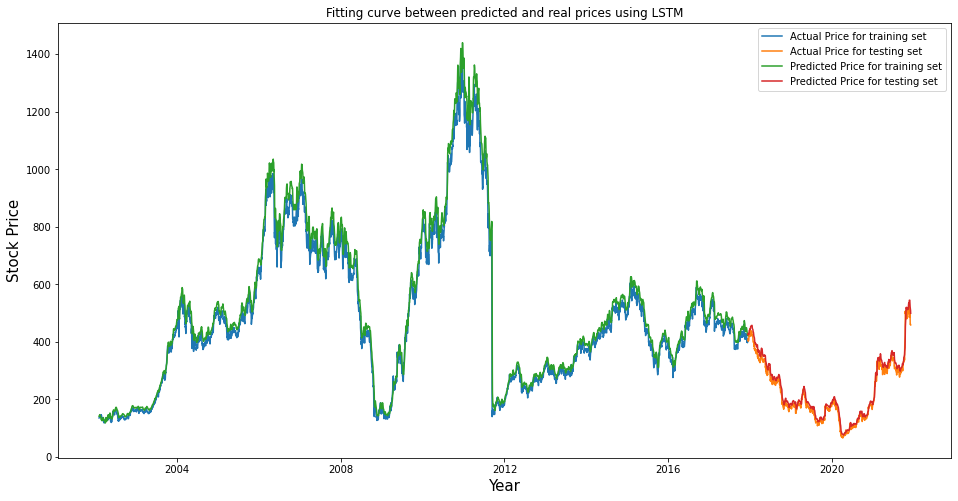

In [ ]:
plt.figure(figsize=(16,8))
plt.plot(train_df['Close'], label='Actual Price for training set')
plt.plot(test_df['Close'], label='Actual Price for testing set')
plt.plot(train_df['Predictions'], label='Predicted Price for training set')
plt.plot(test_df['Predictions'], label='Predicted Price for testing set')
# plt.plot(future_df['Predictions'], label='Predicted Price for future set')
plt.xlabel('Year', fontsize=15)
plt.ylabel('Stock Price', fontsize=15)
plt.title('Fitting curve between predicted and real prices using LSTM')
plt.legend()

plt.show()

In [ ]:
new_df = pd.DataFrame({"Method":["Linear Regression", "KNN", "SVM", "Random Forest", "LSTM"],
                       "R-Square Error(Training)": [r2_linear_train, r2_knn_train, r2_svm_train, r2_rf_train, r2_lstm_train],
                        "R-Square Error(Testing)": [r2_linear_test, r2_knn_test, r2_svm_test, r2_rf_test, r2_lstm_test],
                       "Mean Absolute Error(Training)": [mae_linear_train, mae_knn_train, mae_svm_train, mae_rf_train, mae_lstm_train],
                        "Mean Absolute Square Error(Testing)": [mae_linear_test, mae_knn_test, mae_svm_test, mae_rf_test, mae_lstm_test],
                       "Root Mean Square Error(Training)": [rms_linear_train, rms_knn_train, rms_svm_train, rms_rf_train, rms_lstm_train],
                        "Root Mean Square Error(Testing)": [rms_linear_test, rms_knn_test, rms_svm_test, rms_rf_test, rms_lstm_test],
                       })
new_df

,Method,R-Square Error(Training),R-Square Error(Testing),Mean Absolute Error(Training),Mean Absolute Square Error(Testing),Root Mean Square Error(Training),Root Mean Square Error(Testing)
0,Linear Regression,0.011879,-8.055750,206.250793,294.040623,262.071880,310.700339
1,KNN,0.506473,-10.412134,133.131669,310.233888,185.212730,348.789132
2,SVM,-0.042827,-4.211153,198.681717,215.426798,269.228717,235.692868
3,Random Forest,0.976416,-8.369983,28.885449,282.349168,40.487611,316.044996
4,LSTM,0.977118,0.971843,29.158167,14.542315,39.596793,17.324916


In [ ]:
new_df = pd.DataFrame({"Dates":['12/1/2021', '12/2/2021', '12/3/2021', '12/6/2021', '12/7/2021', '12/8/2021', '12/9/2021', '12/10/2021', '12/13/2021', '12/14/2021'],
                        "Linear Regression": future_preds_lr,
                       "KNN": future_preds_knn,
                       "SVM": future_preds_svm,
                       "Random Forest": future_preds_rf,
                       "LSTM": nextday_closing_price.flatten()
                       })
new_df

,Dates,Linear Regression,KNN,SVM,Random Forest,LSTM
0,12/1/2021,561.265126,625.350000,439.900214,233.355167,491.736359
1,12/2/2021,524.288731,340.294444,439.900200,230.261000,496.688660
2,12/3/2021,524.484159,340.294444,439.900190,233.209333,513.347656
3,12/6/2021,521.535878,218.622222,439.900100,165.143167,527.991577
4,12/7/2021,521.731306,187.022222,439.900090,161.192667,537.554749
5,12/8/2021,521.926734,215.388889,439.900080,167.328667,548.880554
6,12/9/2021,522.122162,222.683333,439.900070,166.269500,561.068054
7,12/10/2021,522.317590,295.383333,439.900060,197.971833,573.813110
8,12/13/2021,519.369308,236.211111,439.899970,214.253667,587.354187
9,12/14/2021,519.564736,251.666667,439.899960,247.605667,601.612366
